## Test program

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn

import torchvision.transforms as transforms

import numpy as np

import torchvision
import torch

In [3]:
from tqdm import tqdm

In [4]:
device = 'cuda'

In [5]:
import sys
sys.path.append("src")

In [6]:
from train_classifier import get_model

In [42]:
net = get_model("resnet101")
model_path = "models/resnet101_allfonts_mnist.pth"

# net = get_model("resnet50")
# model_path = "resnet50_mnist.pth"

In [43]:
net.load_state_dict(torch.load(model_path))

net = net.to(device)

## Extract features from picture

In [44]:
import cv2
import matplotlib.pyplot as plt


from data_preprocessing import crop_and_warp, find_corners_of_largest_polygon, pre_process_image, remove_stuff


In [45]:
import os

In [46]:
file_names = [f"sudoku_real_{i}.jpeg" for i in range(1, 7)]
file_names.append("sudoku_real_7.png")
file_names.extend([f"sudoku_real_{i}.jpeg" for i in range(8, 10)])

In [47]:
selected_i = 8

img_path = os.path.join("sample_data", file_names[selected_i])

In [77]:
print(img_path)

sample_data/sudoku_real_9.jpeg


In [48]:
img = cv2.imread(img_path)


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

pre_preocessed = pre_process_image(gray)

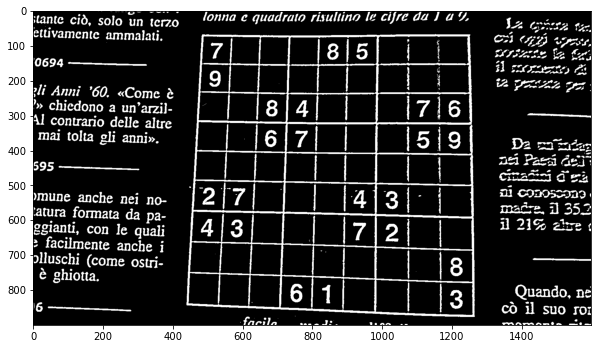

In [84]:
plt.figure(figsize=(10,10))
plt.imshow(pre_preocessed, cmap='gray')



In [82]:
import matplotlib
matplotlib.use('Agg')

In [91]:
plt.imsave("preprocessed.png", pre_preocessed, cmap='gray')

In [ ]:
Input image after basic preprocessing (gaussian filter,  thresholding and color inversion).
Image by author


### Isolate area of the grid

In [94]:
type(pre_preocessed)

numpy.ndarray

In [95]:
corners = find_corners_of_largest_polygon(pre_preocessed)

In [51]:
cropped = crop_and_warp(pre_preocessed, corners)

## Solve sudoku!

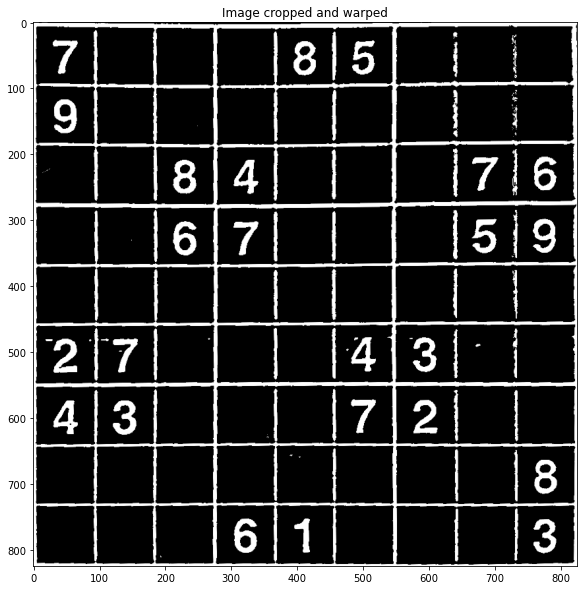

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(cropped, cmap='gray')
plt.title("Image cropped and warped");

In [97]:
plt.imsave("cropped.png", cropped, cmap='gray')


In [53]:
_, cropped_t = cv2.threshold(cropped,127,255,cv2.THRESH_TOZERO)

In [54]:
cropped = cropped_t

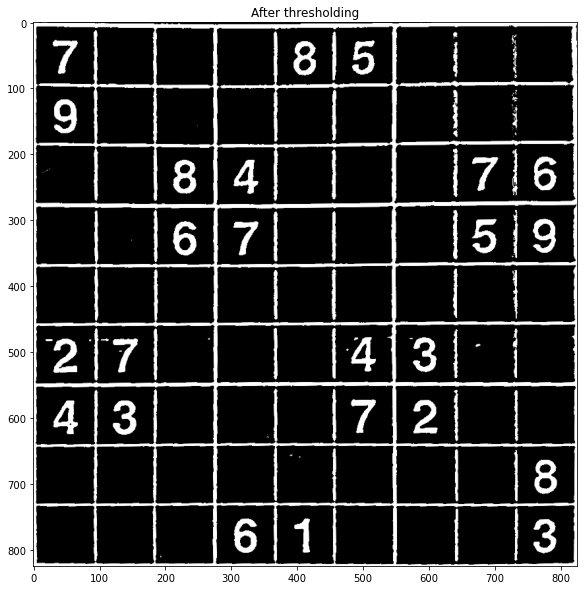

In [55]:
plt.figure(figsize=(10,10))
plt.imshow(cropped_t, cmap='gray')
plt.title("After thresholding");

In [56]:
def slice_grid(grid, i, j, W):
    """
    Assuming grid is an array representing the image, return a single square
    based on its coordinates (which start from 0). 
    """
    
    i_start = i * W
    i_end = i_start + W
    
    j_start = j * W
    j_end = j_start + W
        
    aa = grid[i_start:i_end, j_start:j_end]
    return aa
    

In [57]:
w, h = cropped.shape

W = w//9


In [58]:
from classifier import smart_classify

In [59]:
w, h = cropped.shape

W = w//9

In [60]:
digits = list()

for i in range(9):
    
    for j in range(9):
        
        # Slice a cell from the original image
        aa = slice_grid(cropped_t, i, j, W)
        
        bb = aa.astype(float)/255

        # Isolate digit from rest of the cell
        out = remove_stuff(bb)
        
        # Resize to 28x28
        resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)
        digits.append(smart_classify(resized, net, conf_threshold=0.9))

In [61]:
def convert(d):
    if d == ' ':
        return 0
    else:
        return int(d)

In [62]:
from sudoku_solver import print_board, solve_array

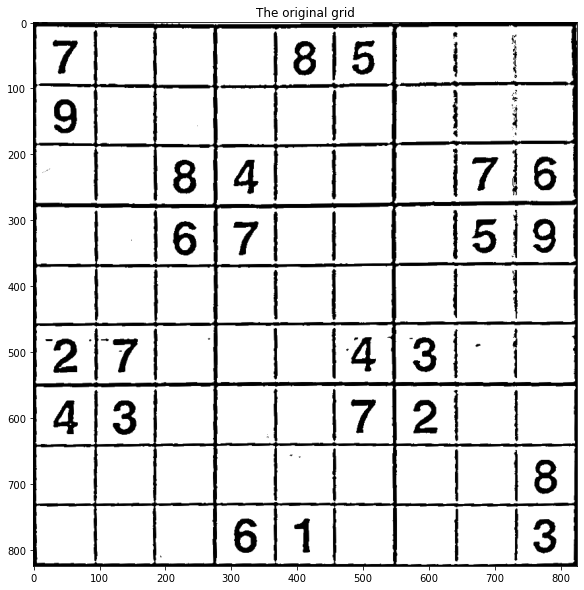

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(255-cropped, cmap='gray')
plt.title("The original grid");

In [64]:
digits_int = np.array([convert(d) for d in digits])

digits_int = digits_int.reshape((9, 9))

In [65]:
digits_list = [list(ll) for ll in list(digits_int)]

In [66]:
print_board(digits_list)

7 . .  | . 8 5  | . . .
9 . .  | . . .  | . . .
. . 8  | 4 . .  | . 7 6
- - - - - - - - - - - - - 
. . 6  | 7 . .  | . 5 9
. . .  | . . .  | . . .
2 7 .  | . . 4  | 3 . .
- - - - - - - - - - - - - 
4 3 .  | . . 7  | 2 . .
. . .  | . . .  | . . 8
. . .  | 6 1 .  | . . 3


In [67]:

digits_list = list(digits_list)

solve_array(digits_list)

True

In [68]:
print_board(digits_list)

7 6 3  | 2 8 5  | 1 9 4
9 5 4  | 1 7 6  | 8 3 2
1 2 8  | 4 3 9  | 5 7 6
- - - - - - - - - - - - - 
3 1 6  | 7 2 8  | 4 5 9
8 4 9  | 3 5 1  | 6 2 7
2 7 5  | 9 6 4  | 3 8 1
- - - - - - - - - - - - - 
4 3 1  | 8 9 7  | 2 6 5
6 9 2  | 5 4 3  | 7 1 8
5 8 7  | 6 1 2  | 9 4 3


## DEBUG

In [69]:
# Coordinates in the natural system (row, column values from 1 to 9)
coordinates = 9, 5

In [70]:
i, j = coordinates
i -= 1
j -= 1

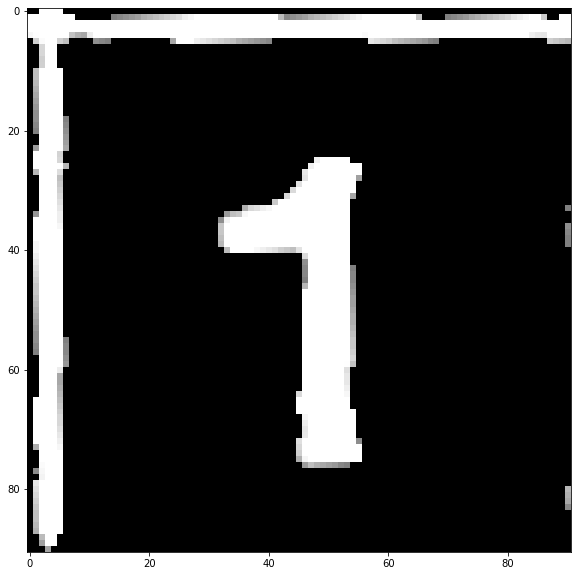

In [103]:
aa = slice_grid(cropped, i, j, W)
aa = aa.astype(np.float32)/255
plt.figure(figsize=(10,10))
plt.imshow(aa, cmap='gray')

In [104]:
plt.imsave("one_cell_dirty.png", aa, cmap='gray')

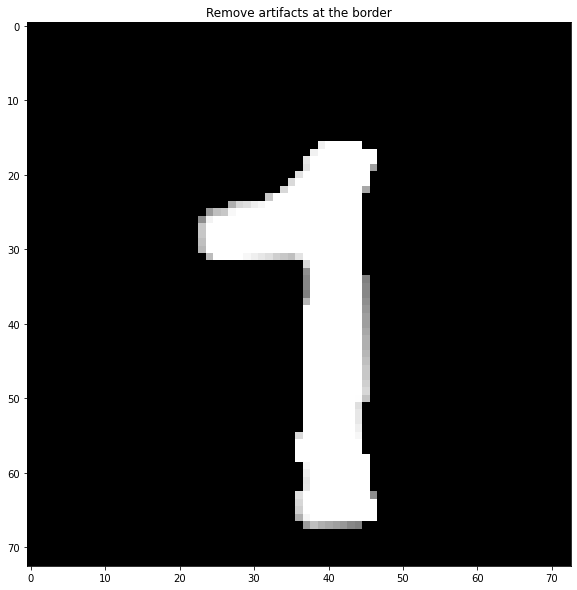

In [98]:
out = remove_stuff(aa)
# out = aa

plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray')
plt.title("Remove artifacts at the border");

In [106]:
plt.imsave("one_cell_clean.png", out, cmap='gray')

In [99]:
resized = cv2.resize(out, (28, 28), interpolation = cv2.INTER_AREA)

In [108]:
plt.imsave("one_cell_resized.png", resized, cmap='gray')

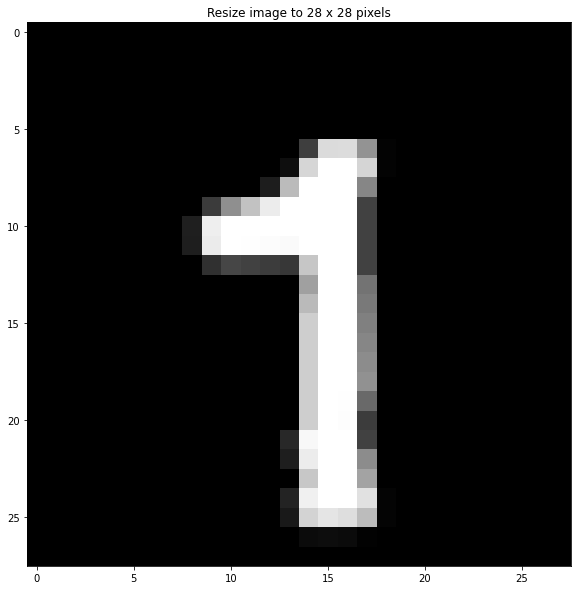

In [100]:
plt.figure(figsize=(10,10))
plt.imshow(resized, cmap='gray')
plt.title("Resize image to 28 x 28 pixels");

In [101]:
(resized != resized.min()).sum()

118

In [102]:
smart_classify(resized, net, debug=True)

Logits: tensor([[-3.0976, 12.8741, -2.0427,  0.3675, -0.6079, -3.2224, -3.4531,  2.2325,
         -4.8565, -4.1889]], device='cuda:0')
Softmax: tensor([[1.1577e-07, 9.9997e-01, 3.3245e-07, 3.7023e-06, 1.3959e-06, 1.0219e-07,
         8.1128e-08, 2.3901e-05, 1.9938e-08, 3.8873e-08]], device='cuda:0')
Predicted digit: 1 with confidence 1.000


'1'